In [48]:
# File system
import os, os.path 
import pickle
from glob import glob

# Computation
import numpy as np
import torch
import tqdm
import tqdm.notebook

# Data visualization
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [49]:
%matplotlib inline
sns.set(rc={"figure.dpi":100, 'savefig.dpi':100})
sns.set_context('notebook')

In [50]:
# Used for testing small inputs
# dummy_train_path = './dummy_train'
# dummy_test_path = './dummy_val'
# cur_train_path = dummy_train_path
# cur_test_path = dummy_test_path

train_path = './new_train/'
test_path = './new_val_in'
cur_train_path = train_path
cur_test_path = test_path

# Path to model predictions on test set
pred_path = './my_submission.csv'

# Header of predictions CSV file
CSV_HEADER = ['ID,'] + ['v' + str(i) + ',' for i in range(1, 60)] + ['v60', '\n']

BSZ_TRAIN = 16
BSZ_TEST = 8
NUM_WORKERS = 4
PF_FACTOR = 4
# used for visualizing the loss
loss_vis = []

# Dataset Loading and Batching

In [51]:
class ArgoverseDataset(torch.utils.data.Dataset):
    """Dataset class for Argoverse"""
    def __init__(self, data_path: str, transform=None):
        super(ArgoverseDataset, self).__init__()
        self.data_path = data_path
        self.transform = transform

        self.pkl_list = glob(os.path.join(self.data_path, '*'))
        self.pkl_list.sort()
        
    def __len__(self):
        return len(self.pkl_list)

    def __getitem__(self, idx):

        pkl_path = self.pkl_list[idx]
        with open(pkl_path, 'rb') as f:
            data = pickle.load(f)
            
        if self.transform:
            data = self.transform(data)

        return data

In [60]:
def collate_train(batch):
    """ 
    Custom collate_fn function to be used for DataLoader. 
    
    batch - list of objects in the current batch. Has len == batch_size_train
    
    collate lists of samples into batches, create [ batch_sz,  agent_sz, seq_len, feature] 
    """    
    # Only including the measurements for the tracked agent
    inp = []        
    out = []
    scene_idxs = []
    for scene in batch:
        # Get the target agent id
        agent_id = scene['agent_id']
        
        # Get the matrix of all agents
        track_id = scene['track_id']
        
        # Get the location of the target agent in the matrix
        tup = np.nonzero(track_id[:, 0] == agent_id)
        row_idx = tup[0][0]        
        
        inp.append(np.concatenate( (scene['p_in'][row_idx], scene['v_in'][row_idx]), axis=1) )
        out.append(scene['p_out'][row_idx].flatten()) 
#         scene_idxs.append(scene['scene_idx'])
        

    inp = torch.FloatTensor(inp)
    out = torch.FloatTensor(out)    

    return [inp, out, scene_idxs]

In [61]:
def collate_test(batch):
    """ 
    Custom collate_fn for validation dataset. The validation data do not contain output values.   
    """   
    # Only include the measurements for the tracked agent
    inp = []
    for scene in batch:
        # Get the target agent id
        agent_id = scene['agent_id']
        
        # Get the matrix of all agents
        track_id = scene['track_id']
        
        # Get the location of the target agent in the matrix
        tup = np.nonzero(track_id[:, 0] == agent_id)
        row_idx = tup[0][0]
                
        inp.append(np.concatenate( (scene['p_in'][row_idx], scene['v_in'][row_idx]), axis=1) )
        
    inp = torch.FloatTensor(inp)
    
    # The out tensor is just the scene index; this allows for a prediction to be associated
    # with a certain scene
    out = [scene['scene_idx'] for scene in batch]
    out = torch.LongTensor(out)
    
    return [inp, out]

In [62]:
# Initiliaze datasets and loaders
train_dataset = ArgoverseDataset(data_path=cur_train_path)
test_dataset = ArgoverseDataset(data_path=cur_test_path)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BSZ_TRAIN, 
                                           shuffle=True, collate_fn=collate_train, 
                                           num_workers=NUM_WORKERS, drop_last=True)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BSZ_TEST, 
                                          shuffle=False, collate_fn=collate_test)

In [63]:
# Look at one data sample      
for i_batch, sample_batch in enumerate(train_loader):
    data, target, scene_idxs = sample_batch
    
    print(data.shape)
    print(target.shape)
    print(scene_idxs)
    break

torch.Size([16, 19, 4])
torch.Size([16, 60])
[]


# Training Workflow and Model Definition 

In [64]:
def train(model, device, train_loader, optimizer, epoch):
    # Set the model into training mode
    model.train()
    
    iterator = tqdm.notebook.tqdm(train_loader, total=int(len(train_loader)))
    counter = 0
    
    for batch_idx, (data, target, _) in enumerate(iterator):
        data, target = data.to(device), target.to(device)
                
        # Reset gradients, since they get accumulated each iteration
        optimizer.zero_grad()
        
        # Make predictions
        output = model(data)
        
        # Compute the loss
#         loss = torch.sqrt(torch.nn.functional.mse_loss(output, target))
        loss = torch.nn.functional.mse_loss(output, target)
        
        # Record the loss - for visualization
#         loss_vis.append(loss.item())
                
        # Perform backpropagation
        loss.backward()
        
        # Actually update the weights
        optimizer.step()
        
        counter += 1
        iterator.set_postfix(loss=(loss.item()*data.size(0) / (counter * train_loader.batch_size)))

In [65]:
def predict(model, device, test_loader, path):
    """
    path: path to csv file to write predictions
    """
    # Set model into evaluation mode
    model.eval()   
    
    with open(pred_path, "w") as csv_file:
        # Clear the csv file before appending data to it
        csv_file.truncate()
        # Write the header to the csv file
        csv_file.writelines(CSV_HEADER)    
    
    with open(path, "a") as pred_file:        
        iterator = tqdm.notebook.tqdm(test_loader, total=int(len(test_loader)))
        
        for batch_idx, (data, target) in enumerate(iterator):
            data = data.to(device) 
            # Make predictions
            output = model(data)
            # Convert the Tensor from GPU -> CPU -> NumPy array
            np_out = output.cpu().detach().numpy()            
            # Get the scene index
            scene_idx = target.numpy()
            
            # Form comma-separated string
            s = []
            for i in range(np_out.shape[0]):
                s.append(','.join([str(scene_idx[i])] + [str(v) for v in np_out[i]]) + '\n')
            
            # Write data to file
            pred_file.writelines(s)

In [66]:
class BNN(torch.nn.Module):
    """
    Bearl Neural Network
    """
    def __init__(self):
        super(BNN, self).__init__()    
        
        
        self.fc = torch.nn.Sequential(
            torch.nn.Linear(1 * 19 * 4, 120),
            torch.nn.ReLU(),
            torch.nn.Linear(120, 60),         
        )        
                 
    
    def forward(self, x):
#         print(f"Calling forward: shape of x = {x.shape}")        
        x = x.view(x.size(0), -1)  # flatten result
        x = self.fc(x)    
        return x

# Model Initialization

In [67]:
DEVICE = 'cuda'
model = BNN().to(DEVICE, dtype=torch.float)
num_params = sum(p.numel() for p in model.parameters())   
print(f"Number of model parameters is {num_params}")
NUM_EPOCH = 10

learning_rate = 1e-0
momentum = 0.9
# weight_decay = 1
# optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)
# optimizer = torch.optim.Adadelta(model.parameters())  # Used to generate visualizations in report
# optimizer = torch.optim.ASGD(model.parameters())
# optimizer = torch.optim.AdamW(model.parameters(), betas=(0.5, 0.9))
# optimizer = torch.optim.Adamax(model.parameters())
# optimizer = torch.optim.RMSprop(model.parameters())


Number of model parameters is 16500


In [68]:
# Train the model and make predictions
train(model, DEVICE, train_loader, optimizer, NUM_EPOCH)
predict(model, DEVICE, test_loader, pred_path)

In [28]:
train(model, DEVICE, train_loader, optimizer, 4)

# Loss Visualization

In [92]:
def visualize_loss(losses):
    """
    Plots the losses over each training iteration. 
    Assumes that each element of the 'losses' list corresponds to the loss after each batch of train()
    """
    t_iter = np.arange(1, len(losses) + 1, 1, dtype=int)
    ax = sns.scatterplot(x=t_iter, y=losses, alpha=0.5)    
    ax.set_xlabel('Batch iteration number')
    ax.set_ylabel('Root-mean-square loss')
    ax.set_title('Batch Iteration vs. Root-Mean-Square Loss')
    plt.savefig('lossViter')

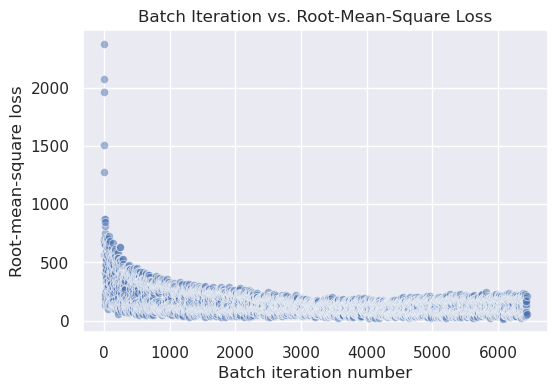

In [93]:
visualize_loss(loss_vis)

# Ground Truth Comparison

In [54]:
def visualize_predictions(model, device, loader):
    """
    Compares some randomly selected data samples to the model's predictions
    """
    model.eval()
    
    # Get a batch of data
    _, (data, target, scene_idxs) = next(enumerate(loader))
    data, target = data.to(device), target.to(device)
    
    # Sample number
    i = 0
    
    # Scene idx
    scene_idx = scene_idxs[i]
    
    # Get contiguous arrays of the ground truth output positions
    sample = target[i].cpu().detach().numpy()
    # Every even-indexed element is an x position, every odd-indexed element is a y position
    x = sample[::2]
    y = sample[1::2]   
    
    # Get contiguous arrays of the prediction output positions
    output = model(data)    
    pred = output[i].cpu().detach().numpy()
    xh = pred[::2]
    yh = pred[1::2]
    
    # Plot the ground truth and prediction positions
    fig, (ax) = plt.subplots(nrows=1, ncols=1, figsize=(3, 3))
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_title('Scene ' + str(scene_idx))
    ax.scatter(x, y, label='Ground Truth')
    ax.scatter(xh, yh, label='Prediction')
    ax.legend()

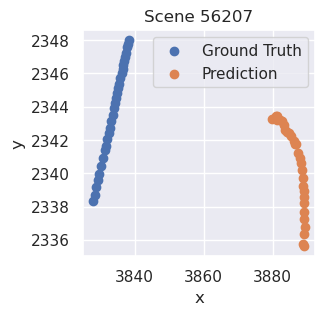

In [70]:
visualize_predictions(model, DEVICE, train_loader)